In [2]:
!pip install scikit-learn==0.24.1

In [46]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
from sklearn.metrics import plot_confusion_matrix
from sklearn.linear_model import LogisticRegression

import tensorflow as tf

In [4]:


data = pd.read_csv('https://raw.githubusercontent.com/FT-Kickstarter-05/Kickstarter/main/2018_ks_data.csv')

In [5]:
data.head()

,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,usd_pledged_real,usd_goal_real
0,1000002330,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,2015-10-09,1000.0,2015-08-11 12:12:28,0.0,failed,0,GB,0.0,0.0,1533.95
1,1000003930,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,Film & Video,USD,2017-11-01,30000.0,2017-09-02 04:43:57,2421.0,failed,15,US,100.0,2421.0,30000.00
2,1000004038,Where is Hank?,Narrative Film,Film & Video,USD,2013-02-26,45000.0,2013-01-12 00:20:50,220.0,failed,3,US,220.0,220.0,45000.00
3,1000007540,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,USD,2012-04-16,5000.0,2012-03-17 03:24:11,1.0,failed,1,US,1.0,1.0,5000.00
4,1000011046,Community Film Project: The Art of Neighborhoo...,Film & Video,Film & Video,USD,2015-08-29,19500.0,2015-07-04 08:35:03,1283.0,canceled,14,US,1283.0,1283.0,19500.00


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 378661 entries, 0 to 378660
Data columns (total 15 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   ID                378661 non-null  int64  
 1   name              378657 non-null  object 
 2   category          378661 non-null  object 
 3   main_category     378661 non-null  object 
 4   currency          378661 non-null  object 
 5   deadline          378661 non-null  object 
 6   goal              378661 non-null  float64
 7   launched          378661 non-null  object 
 8   pledged           378661 non-null  float64
 9   state             378661 non-null  object 
 10  backers           378661 non-null  int64  
 11  country           378661 non-null  object 
 12  usd pledged       374864 non-null  float64
 13  usd_pledged_real  378661 non-null  float64
 14  usd_goal_real     378661 non-null  float64
dtypes: float64(5), int64(2), object(8)
memory usage: 43.3+ MB


# Cleaning and preprocessing 

In [7]:
unneeded_columns = ['ID', 'name']
data = data.drop(unneeded_columns, axis=1)

In [8]:
data.head()

,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,usd_pledged_real,usd_goal_real
0,Poetry,Publishing,GBP,2015-10-09,1000.0,2015-08-11 12:12:28,0.0,failed,0,GB,0.0,0.0,1533.95
1,Narrative Film,Film & Video,USD,2017-11-01,30000.0,2017-09-02 04:43:57,2421.0,failed,15,US,100.0,2421.0,30000.00
2,Narrative Film,Film & Video,USD,2013-02-26,45000.0,2013-01-12 00:20:50,220.0,failed,3,US,220.0,220.0,45000.00
3,Music,Music,USD,2012-04-16,5000.0,2012-03-17 03:24:11,1.0,failed,1,US,1.0,1.0,5000.00
4,Film & Video,Film & Video,USD,2015-08-29,19500.0,2015-07-04 08:35:03,1283.0,canceled,14,US,1283.0,1283.0,19500.00


In [9]:
data.isna().sum()

category               0
main_category          0
currency               0
deadline               0
goal                   0
launched               0
pledged                0
state                  0
backers                0
country                0
usd pledged         3797
usd_pledged_real       0
usd_goal_real          0
dtype: int64

In [10]:
data['usd pledged'].mean()

7036.728867109212

In [11]:
data['usd pledged'] = data['usd pledged'].fillna(data['usd pledged'].mean())

In [12]:
data.isna().sum()

category            0
main_category       0
currency            0
deadline            0
goal                0
launched            0
pledged             0
state               0
backers             0
country             0
usd pledged         0
usd_pledged_real    0
usd_goal_real       0
dtype: int64

In [13]:
data.isna().sum().sum()

0

In [14]:
data['state'].unique()

array(['failed', 'canceled', 'successful', 'live', 'undefined',
       'suspended'], dtype=object)

In [15]:
data.query("state != 'failed' and state != 'successful'")

,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,usd_pledged_real,usd_goal_real
4,Film & Video,Film & Video,USD,2015-08-29,19500.0,2015-07-04 08:35:03,1283.00,canceled,14,US,1283.00,1283.00,19500.00
8,Product Design,Design,USD,2014-05-29,125000.0,2014-04-24 18:14:43,8233.00,canceled,58,US,8233.00,8233.00,125000.00
9,Documentary,Film & Video,USD,2014-08-10,65000.0,2014-07-11 21:55:48,6240.57,canceled,43,US,6240.57,6240.57,65000.00
40,Nonfiction,Publishing,CAD,2018-01-19,3000.0,2017-11-20 18:15:14,592.00,live,24,CA,185.65,472.88,2396.36
68,Design,Design,CAD,2015-08-07,15000.0,2015-07-08 21:46:53,700.00,canceled,6,CA,553.32,535.09,11466.14
...,...,...,...,...,...,...,...,...,...,...,...,...,...
378640,Fiction,Publishing,USD,2014-09-11,1000.0,2014-08-08 21:49:31,100.00,canceled,2,US,100.00,100.00,1000.00
378643,3D Printing,Technology,USD,2014-05-26,6500.0,2014-05-05 20:22:45,0.00,canceled,0,US,0.00,0.00,6500.00
378648,Tabletop Games,Games,USD,2016-02-23,500.0,2016-01-24 16:03:27,121.00,canceled,5,US,121.00,121.00,500.00
378655,Poetry,Publishing,CAD,2014-09-20,5500.0,2014-08-06 03:46:07,0.00,canceled,0,CA,0.00,0.00,4949.60


In [16]:
data.shape

(378661, 13)

In [17]:
data.query("state != 'failed' and state != 'successful'").index

Int64Index([     4,      8,      9,     40,     68,     70,     73,     74,
                93,    104,
            ...
            378589, 378593, 378601, 378624, 378626, 378640, 378643, 378648,
            378655, 378656],
           dtype='int64', length=46986)

In [18]:
data = data.drop(data.query("state != 'failed' and state != 'successful'").index, axis=0).reset_index(drop=True)

In [19]:
print(data.shape)
data.head()

(331675, 13)


,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,usd_pledged_real,usd_goal_real
0,Poetry,Publishing,GBP,2015-10-09,1000.0,2015-08-11 12:12:28,0.0,failed,0,GB,0.0,0.0,1533.95
1,Narrative Film,Film & Video,USD,2017-11-01,30000.0,2017-09-02 04:43:57,2421.0,failed,15,US,100.0,2421.0,30000.00
2,Narrative Film,Film & Video,USD,2013-02-26,45000.0,2013-01-12 00:20:50,220.0,failed,3,US,220.0,220.0,45000.00
3,Music,Music,USD,2012-04-16,5000.0,2012-03-17 03:24:11,1.0,failed,1,US,1.0,1.0,5000.00
4,Restaurants,Food,USD,2016-04-01,50000.0,2016-02-26 13:38:27,52375.0,successful,224,US,52375.0,52375.0,50000.00


In [20]:
data['state'].unique()

array(['failed', 'successful'], dtype=object)

# Feature Engineering and Encoding

### Change Date to month and year and delete date
### For deadline and launched dates

In [21]:
data.head()

,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,usd_pledged_real,usd_goal_real
0,Poetry,Publishing,GBP,2015-10-09,1000.0,2015-08-11 12:12:28,0.0,failed,0,GB,0.0,0.0,1533.95
1,Narrative Film,Film & Video,USD,2017-11-01,30000.0,2017-09-02 04:43:57,2421.0,failed,15,US,100.0,2421.0,30000.00
2,Narrative Film,Film & Video,USD,2013-02-26,45000.0,2013-01-12 00:20:50,220.0,failed,3,US,220.0,220.0,45000.00
3,Music,Music,USD,2012-04-16,5000.0,2012-03-17 03:24:11,1.0,failed,1,US,1.0,1.0,5000.00
4,Restaurants,Food,USD,2016-04-01,50000.0,2016-02-26 13:38:27,52375.0,successful,224,US,52375.0,52375.0,50000.00


In [22]:
data['deadline'].apply(lambda x: x[0:4])

0         2015
1         2017
2         2013
3         2012
4         2016
          ... 
331670    2017
331671    2011
331672    2010
331673    2016
331674    2011
Name: deadline, Length: 331675, dtype: object

In [23]:
data['deadline'].apply(lambda x: x[5:7])

0         10
1         11
2         02
3         04
4         04
          ..
331670    04
331671    07
331672    08
331673    02
331674    08
Name: deadline, Length: 331675, dtype: object

In [24]:
data['deadline_year'] = data['deadline'].apply(lambda x: np.float(x[0:4]))
data['deadline_month'] = data['deadline'].apply(lambda x: np.float(x[5:7]))

data['launched_year'] = data['launched'].apply(lambda x: np.float(x[0:4]))
data['launched_month'] = data['launched'].apply(lambda x: np.float(x[5:7]))

data = data.drop(['deadline', 'launched'], axis=1)

### Binary encode 'state' column

In [25]:
data['state'].apply(lambda x: 1 if x == 'successful' else 0)

0         0
1         0
2         0
3         0
4         1
         ..
331670    0
331671    0
331672    0
331673    0
331674    0
Name: state, Length: 331675, dtype: int64

In [26]:
data['state'] = data['state'].apply(lambda x: 1 if x == 'successful' else 0)

In [27]:
data.head()

,category,main_category,currency,goal,pledged,state,backers,country,usd pledged,usd_pledged_real,usd_goal_real,deadline_year,deadline_month,launched_year,launched_month
0,Poetry,Publishing,GBP,1000.0,0.0,0,0,GB,0.0,0.0,1533.95,2015.0,10.0,2015.0,8.0
1,Narrative Film,Film & Video,USD,30000.0,2421.0,0,15,US,100.0,2421.0,30000.00,2017.0,11.0,2017.0,9.0
2,Narrative Film,Film & Video,USD,45000.0,220.0,0,3,US,220.0,220.0,45000.00,2013.0,2.0,2013.0,1.0
3,Music,Music,USD,5000.0,1.0,0,1,US,1.0,1.0,5000.00,2012.0,4.0,2012.0,3.0
4,Restaurants,Food,USD,50000.0,52375.0,1,224,US,52375.0,52375.0,50000.00,2016.0,4.0,2016.0,2.0


### OneHotEncode 'category','main_category'
### 'currency'	, 'country'

In [28]:
from sys import prefix
def onehot_encode(df, columns, prefixes):
  df = df.copy()
  for column, prefix in zip(columns, prefixes):
    dummies = pd.get_dummies(df[column], prefix=prefix)
    df = pd.concat([df, dummies], axis=1)
    df = df.drop(column, axis=1)
  return df

In [29]:
data = onehot_encode(
    data,
    ['category', 'main_category', 'currency', 'country'],
    ['cat', 'main_cat', 'curr', 'country']
)

In [30]:
print(data.shape)
data.head()

(331675, 222)


,goal,pledged,state,backers,usd pledged,usd_pledged_real,usd_goal_real,deadline_year,deadline_month,launched_year,launched_month,cat_3D Printing,cat_Academic,cat_Accessories,cat_Action,cat_Animals,cat_Animation,cat_Anthologies,cat_Apparel,cat_Apps,cat_Architecture,cat_Art,cat_Art Books,cat_Audio,cat_Bacon,cat_Blues,cat_Calendars,cat_Camera Equipment,cat_Candles,cat_Ceramics,cat_Children's Books,cat_Childrenswear,cat_Chiptune,cat_Civic Design,cat_Classical Music,cat_Comedy,cat_Comic Books,cat_Comics,cat_Community Gardens,cat_Conceptual Art,...,main_cat_Publishing,main_cat_Technology,main_cat_Theater,curr_AUD,curr_CAD,curr_CHF,curr_DKK,curr_EUR,curr_GBP,curr_HKD,curr_JPY,curr_MXN,curr_NOK,curr_NZD,curr_SEK,curr_SGD,curr_USD,country_AT,country_AU,country_BE,country_CA,country_CH,country_DE,country_DK,country_ES,country_FR,country_GB,country_HK,country_IE,country_IT,country_JP,country_LU,country_MX,"country_N,0""",country_NL,country_NO,country_NZ,country_SE,country_SG,country_US
0,1000.0,0.0,0,0,0.0,0.0,1533.95,2015.0,10.0,2015.0,8.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
1,30000.0,2421.0,0,15,100.0,2421.0,30000.00,2017.0,11.0,2017.0,9.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
2,45000.0,220.0,0,3,220.0,220.0,45000.00,2013.0,2.0,2013.0,1.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
3,5000.0,1.0,0,1,1.0,1.0,5000.00,2012.0,4.0,2012.0,3.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
4,50000.0,52375.0,1,224,52375.0,52375.0,50000.00,2016.0,4.0,2016.0,2.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


# Our Data is fully numeric
### We are ready to split and scale the data

In [31]:
y = data.loc[:, 'state']
X = data.drop('state', axis=1)

### We only want to scale X, we don’t want to scale what we are trying to predict.

In [32]:
scaler = StandardScaler()
X = scaler.fit_transform(X)

### Each column has a mean of 0, and a variance of 1

In [33]:
pd.DataFrame(X)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220
0,-0.038690,-0.104182,-0.120549,-0.092377,-0.102793,-0.036049,0.393629,0.977775,0.424667,0.478937,-0.041418,-0.048458,-0.091268,-0.043311,-0.026285,-0.081957,-0.047191,-0.137632,-0.127273,-0.044038,-0.151959,-0.086602,-0.033101,-0.023367,-0.026571,-0.029582,-0.032502,-0.033778,-0.028806,-0.137996,-0.035523,-0.009975,-0.028331,-0.086088,-0.079209,-0.087025,-0.118343,-0.028596,-0.053027,-0.037064,...,2.890926,-0.297989,-0.178504,-0.14272,-0.196867,-0.044381,-0.052998,-0.212871,3.201933,-0.03795,-0.008328,-0.065363,-0.041998,-0.062096,-0.067627,-0.037023,-1.930580,-0.038268,-0.142665,-0.039741,-0.196826,-0.044381,-0.102313,-0.052912,-0.07536,-0.087498,3.203245,-0.03795,-0.045426,-0.084817,-0.008328,-0.01311,-0.065363,-0.02517,-0.085571,-0.041926,-0.062096,-0.067605,-0.037023,-1.927949
1,-0.012748,-0.080351,-0.105012,-0.091174,-0.077765,-0.010379,1.435697,1.279416,1.460443,0.781327,-0.041418,-0.048458,-0.091268,-0.043311,-0.026285,-0.081957,-0.047191,-0.137632,-0.127273,-0.044038,-0.151959,-0.086602,-0.033101,-0.023367,-0.026571,-0.029582,-0.032502,-0.033778,-0.028806,-0.137996,-0.035523,-0.009975,-0.028331,-0.086088,-0.079209,-0.087025,-0.118343,-0.028596,-0.053027,-0.037064,...,-0.345910,-0.297989,-0.178504,-0.14272,-0.196867,-0.044381,-0.052998,-0.212871,-0.312311,-0.03795,-0.008328,-0.065363,-0.041998,-0.062096,-0.067627,-0.037023,0.517979,-0.038268,-0.142665,-0.039741,-0.196826,-0.044381,-0.102313,-0.052912,-0.07536,-0.087498,-0.312183,-0.03795,-0.045426,-0.084817,-0.008328,-0.01311,-0.065363,-0.02517,-0.085571,-0.041926,-0.062096,-0.067605,-0.037023,0.518686
2,0.000669,-0.102016,-0.117442,-0.089732,-0.100519,0.003147,-0.648438,-1.435355,-0.611109,-1.637795,-0.041418,-0.048458,-0.091268,-0.043311,-0.026285,-0.081957,-0.047191,-0.137632,-0.127273,-0.044038,-0.151959,-0.086602,-0.033101,-0.023367,-0.026571,-0.029582,-0.032502,-0.033778,-0.028806,-0.137996,-0.035523,-0.009975,-0.028331,-0.086088,-0.079209,-0.087025,-0.118343,-0.028596,-0.053027,-0.037064,...,-0.345910,-0.297989,-0.178504,-0.14272,-0.196867,-0.044381,-0.052998,-0.212871,-0.312311,-0.03795,-0.008328,-0.065363,-0.041998,-0.062096,-0.067627,-0.037023,0.517979,-0.038268,-0.142665,-0.039741,-0.196826,-0.044381,-0.102313,-0.052912,-0.07536,-0.087498,-0.312183,-0.03795,-0.045426,-0.084817,-0.008328,-0.01311,-0.065363,-0.02517,-0.085571,-0.041926,-0.062096,-0.067605,-0.037023,0.518686
3,-0.035111,-0.104172,-0.119514,-0.092365,-0.102783,-0.032924,-1.169472,-0.832072,-1.128997,-1.033015,-0.041418,-0.048458,-0.091268,-0.043311,-0.026285,-0.081957,-0.047191,-0.137632,-0.127273,-0.044038,-0.151959,-0.086602,-0.033101,-0.023367,-0.026571,-0.029582,-0.032502,-0.033778,-0.028806,-0.137996,-0.035523,-0.009975,-0.028331,-0.086088,-0.079209,-0.087025,-0.118343,-0.028596,-0.053027,-0.037064,...,-0.345910,-0.297989,-0.178504,-0.14272,-0.196867,-0.044381,-0.052998,-0.212871,-0.312311,-0.03795,-0.008328,-0.065363,-0.041998,-0.062096,-0.067627,-0.037023,0.517979,-0.038268,-0.142665,-0.039741,-0.196826,-0.044381,-0.102313,-0.052912,-0.07536,-0.087498,-0.312183,-0.03795,-0.045426,-0.084817,-0.008328,-0.01311,-0.065363,-0.02517,-0.085571,-0.041926,-0.062096,-0.067605,-0.037023,0.518686
4,0.005142,0.411363,0.111472,0.537260,0.438647,0.007656,0.914663,-0.832072,0.942555,-1.335405,-0.041418,-0.048458,-0.091268,-0.043311,-0.026285,-0.081957,-0.047191,-0.137632,-0.127273,-0.044038,-0.151959,-0.086602,-0.033101,-0.023367,-0.026571,-0.029582,-0.032502,-0.033778,-0.028806,-0.137996,-0.035523,-0.009975,-0.028331,-0.086088,-0.079209,-0.087025,-0.118343,-0.028596,-0.053027,-0.037064,...,-0.345910,-0.297989,-0.178504,-0.14272,-0.196867,-0.044381,-0.052998,-0.212871,-0.312311,-0.03795,-0.008328,-0.065363,-0.041998,-0.062096,-0.06762

### Split Data

In [34]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=34)

### Modeling and Training

In [35]:
X.shape

(331675, 221)

In [36]:
y.shape

(331675,)

### How skewed our our classes

In [37]:
y.mean()

0.4038772895153388

### 40% positive and 60% negative 

### We will use class_weight from SKLearn
### It allows us to generate weights for all the imbalanced classes

In [38]:
y_train.unique()

array([0, 1])

In [39]:
# This will compute class weights on y_train for classes in y_train.unique()
# with a mode of balanced.
class_weights = class_weight.compute_class_weight(
                                        "balanced",
                                        y_train.unique(),
                                        y_train                                                    
                                    )
class_weights = dict(enumerate(class_weights))
class_weights

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:72: FutureWarning: Pass classes=[0 1], y=270640    0
72886     0
43654     1
126262    0
250713    0
         ..
38435     1
199765    0
225014    0
153449    1
305642    0
Name: state, Length: 232172, dtype: int64 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)


{0: 0.8394874242489985, 1: 1.236404302907658}

In [40]:
inputs = tf.keras.Input(shape=(221,))
x = tf.keras.layers.Dense(64, activation='relu')(inputs)
x = tf.keras.layers.Dense(64, activation='relu')(x)
outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)

model = tf.keras.Model(inputs, outputs)


model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=[
        'accuracy',
        tf.keras.metrics.AUC(name='auc') # Area Under the Curve of the (ROC)Receiver Operating Curve
    ]
)
batch_size = 64
epochs = 100 # We are using a large amount of epochs because we are using early stopping

history = model.fit(
    X_train,
    y_train,
    validation_split=0.2,
    class_weight=class_weights, # This will assighn weights to the two classes 
    #to penalize the out of balance 
    batch_size=batch_size,
    epochs=epochs,
    callbacks=[
        tf.keras.callbacks.EarlyStopping( # This is a great callback that lets us monitor a metric or loss value
            monitor='val_loss',
            patience=3,
            restore_best_weights=True,
            verbose=1
        )
    ],
    verbose=2
)

Epoch 1/100
2903/2903 - 13s - loss: 0.4508 - accuracy: 0.7904 - auc: 0.8715 - val_loss: 0.3661 - val_accuracy: 0.8376 - val_auc: 0.9227 - 13s/epoch - 4ms/step
Epoch 2/100
2903/2903 - 11s - loss: 0.3169 - accuracy: 0.8648 - auc: 0.9384 - val_loss: 0.2998 - val_accuracy: 0.8721 - val_auc: 0.9478 - 11s/epoch - 4ms/step
Epoch 3/100
2903/2903 - 11s - loss: 0.2754 - accuracy: 0.8832 - auc: 0.9536 - val_loss: 0.2699 - val_accuracy: 0.8855 - val_auc: 0.9584 - 11s/epoch - 4ms/step
Epoch 4/100
2903/2903 - 11s - loss: 0.2459 - accuracy: 0.8962 - auc: 0.9631 - val_loss: 0.2388 - val_accuracy: 0.8991 - val_auc: 0.9644 - 11s/epoch - 4ms/step
Epoch 5/100
2903/2903 - 10s - loss: 0.2251 - accuracy: 0.9058 - auc: 0.9690 - val_loss: 0.2331 - val_accuracy: 0.9051 - val_auc: 0.9695 - 10s/epoch - 4ms/step
Epoch 6/100
2903/2903 - 11s - loss: 0.2098 - accuracy: 0.9120 - auc: 0.9731 - val_loss: 0.2173 - val_accuracy: 0.9095 - val_auc: 0.9721 - 11s/epoch - 4ms/step
Epoch 7/100
2903/2903 - 10s - loss: 0.2010 - a

# Results

In [41]:
test_data = model.evaluate(X_test, y_test)


3110/3110 [==============================] - 11s 4ms/step - loss: 0.1474 - accuracy: 0.9394 - auc: 0.9864


In [42]:
json_string = model.to_json()

In [43]:
json_string

'{"class_name": "Functional", "config": {"name": "model", "layers": [{"class_name": "InputLayer", "config": {"batch_input_shape": [null, 221], "dtype": "float32", "sparse": false, "ragged": false, "name": "input_1"}, "name": "input_1", "inbound_nodes": []}, {"class_name": "Dense", "config": {"name": "dense", "trainable": true, "dtype": "float32", "units": 64, "activation": "relu", "use_bias": true, "kernel_initializer": {"class_name": "GlorotUniform", "config": {"seed": null}}, "bias_initializer": {"class_name": "Zeros", "config": {}}, "kernel_regularizer": null, "bias_regularizer": null, "activity_regularizer": null, "kernel_constraint": null, "bias_constraint": null}, "name": "dense", "inbound_nodes": [[["input_1", 0, 0, {}]]]}, {"class_name": "Dense", "config": {"name": "dense_1", "trainable": true, "dtype": "float32", "units": 64, "activation": "relu", "use_bias": true, "kernel_initializer": {"class_name": "GlorotUniform", "config": {"seed": null}}, "bias_initializer": {"class_name

In [48]:
clf = LogisticRegression()
clf.fit(X_train, y_train);

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


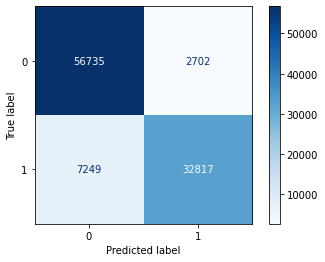

In [65]:
disp = plot_confusion_matrix(clf, X_test, y_test, cmap='Blues')

In [54]:
data.columns

Index(['goal', 'pledged', 'state', 'backers', 'usd pledged',
       'usd_pledged_real', 'usd_goal_real', 'deadline_year', 'deadline_month',
       'launched_year',
       ...
       'country_JP', 'country_LU', 'country_MX', 'country_N,0"', 'country_NL',
       'country_NO', 'country_NZ', 'country_SE', 'country_SG', 'country_US'],
      dtype='object', length=222)

In [55]:
data2 = data[['goal',	'pledged',	'state',	'backers',	'usd pledged',	'usd_pledged_real',	'usd_goal_real',	'deadline_year',	'deadline_month',	'launched_year',	'launched_month']]

In [56]:
data2.head()

,goal,pledged,state,backers,usd pledged,usd_pledged_real,usd_goal_real,deadline_year,deadline_month,launched_year,launched_month
0,1000.0,0.0,0,0,0.0,0.0,1533.95,2015.0,10.0,2015.0,8.0
1,30000.0,2421.0,0,15,100.0,2421.0,30000.00,2017.0,11.0,2017.0,9.0
2,45000.0,220.0,0,3,220.0,220.0,45000.00,2013.0,2.0,2013.0,1.0
3,5000.0,1.0,0,1,1.0,1.0,5000.00,2012.0,4.0,2012.0,3.0
4,50000.0,52375.0,1,224,52375.0,52375.0,50000.00,2016.0,4.0,2016.0,2.0


In [58]:
corr = data2.corr()
corr

,goal,pledged,state,backers,usd pledged,usd_pledged_real,usd_goal_real,deadline_year,deadline_month,launched_year,launched_month
goal,1.000000,0.007965,-0.025099,0.004794,0.006416,0.005955,0.952614,0.016138,0.000556,0.015608,0.000923
pledged,0.007965,1.000000,0.109507,0.717316,0.857014,0.953571,0.005722,0.032338,0.005769,0.032525,0.002207
state,-0.025099,0.109507,1.000000,0.125790,0.095625,0.108298,-0.023735,-0.077555,-0.001867,-0.073835,-0.010488
backers,0.004794,0.717316,0.125790,1.000000,0.697490,0.752291,0.005208,0.019122,0.003232,0.019834,-0.002468
usd pledged,0.006416,0.857014,0.095625,0.697490,1.000000,0.906602,0.006965,-0.005477,-0.003702,-0.005179,-0.006365
usd_pledged_real,0.005955,0.953571,0.108298,0.752291,0.906602,1.000000,0.006354,0.024850,0.004021,0.025158,-0.000207
usd_goal_real,0.952614,0.005722,-0.023735,0.005208,0.006965,0.006354,1.000000,0.012823,0.000992,0.012320,0.001394
deadline_year,0.016138,0.032338,-0.077555,0.019122,-0.005477,0.024850,0.012823,1.000000,-0.072152,0.991875,-0.037276
deadline_month,0.000556,0.005769,-0.001867,0.003232,-0.003702,0.004021,0.000992,-0.072152,1.000000,-0.015546,0.612907
launched_year,0.015608,0.032525,-0.073835,0.019834,-0.005179,0.025158,0.012320,0.991875,-0.015546,1.000000,-0.091069


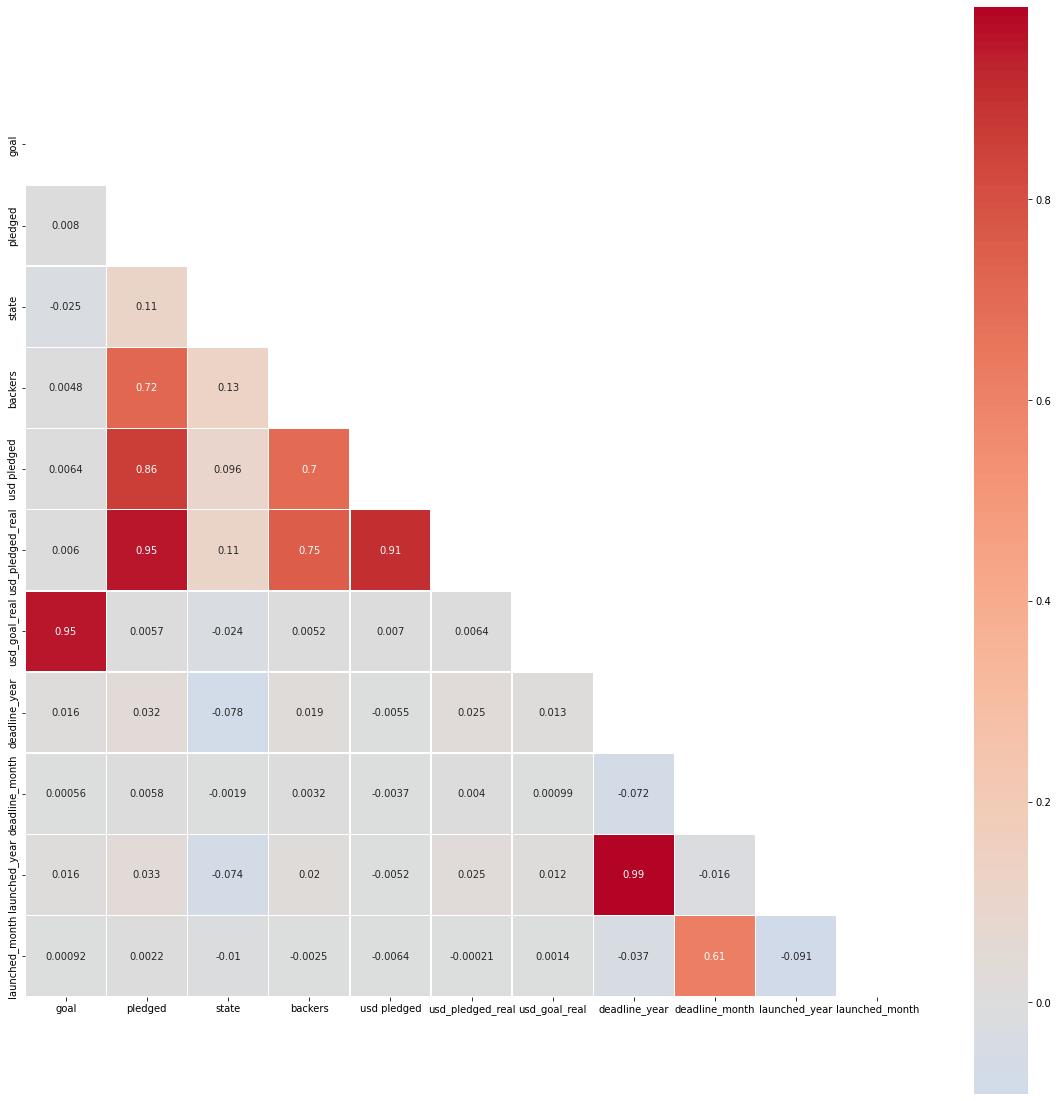

In [67]:
plt.subplots(figsize=(20,20))
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(corr, mask=mask, annot=True, cmap='coolwarm', center=0, linewidths=.5, square=True)